<a href="https://colab.research.google.com/github/alexandrufalk/tensorflow/blob/Master/food_vision2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [34]:
import tensorflow as tf
print(f"Tensorflow version is {tf.__version__}")

Tensorflow version is 2.17.0


In [35]:
# Get GPU name
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-5ca1e208-5748-3100-bd46-5f10cc662bd5)


In [36]:
# Get helper functions file
import os

if not os.path.exists("helper_functions.py"):
    !wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
else:
    print("[INFO] 'helper_functions.py' already exists, skipping download.")

[INFO] 'helper_functions.py' already exists, skipping download.


In [37]:
from helper_functions import create_tensorboard_callback,plot_loss_curves,compare_historys

#TensorFlow Datasets


In [38]:
# Get TensorFlow Datasets
import tensorflow_datasets as tfds

In [6]:
#Get all availabel datasets in TFDS
datasets_lists=tfds.list_builders()

In [7]:
#Set our targhet dataset and see if it exists
targhet_dataset="food101"
print(f"{targhet_dataset} is in TensorFlow Datasets: {targhet_dataset in datasets_lists}" )

food101 is in TensorFlow Datasets: True


In [23]:
#Load in the data
(train_data,test_data), ds_info=tfds.load(name='food101', # target dataset to get from TFDS
                                          split=["train","validation"], # what splits of data should we get? note: not all datasets have train, valid, test
                                          shuffle_files=True,  # shuffle files on download?
                                          as_supervised=True, # download data in tuple format (sample, label), e.g. (image, label)
                                          with_info=True) # include dataset metadata? if so, tfds.load() returns tuple (data, ds_info)

In [ ]:
#Features of food101 tfds
ds_info.features

In [ ]:
#Get class names
class_names=ds_info.features["label"].names
class_names[:10]

In [ ]:
#Take one sample
train_one_sample=train_data.take(1)

In [ ]:
train_one_sample

In [ ]:
for image,label in train_one_sample:
  print(f"""
   Image shape: {image.shape}
   Image dtype: {image.dtype}
   Target class from Food101 (tensor form): {label}
   Class name (str form): {class_names[label.numpy()]}
        """
  )

In [ ]:
image

In [ ]:
#min an dmax values
tf.reduce_min(image),tf.reduce_max(image)

In [ ]:
#Plot an image tensor
import matplotlib.pyplot as plt
plt.imshow(image)
plt.title(class_names[label.numpy()]) # add title to image by indexing on class_names list
plt.axis(False)

#Create preprocessing functions
data is currently:

In uint8 data type

Comprised of all differnet sized tensors (different sized images)

Not scaled (the pixel values are between 0 & 255)

models like data to be:

In float32 data type

Have all of the same size tensors (batches require all tensors have the same shape, e.g. (224, 224, 3))

Scaled (values between 0 & 1), also called normalized


In [39]:
#Function for preprocessing images

def preprocess_img(image,label,img_shape=224):
  """
  Converts image datatype from 'uint8' -> 'float32' and reshapes image to
  [img_shape, img_shape, color_channels]
  """
  image=tf.image.resize(image,[img_shape,img_shape]) #reshape
  return tf.cast(image,tf.float32), label # return (float32_image, label) tuple


In [40]:
# Preprocess a single sample image and check the outputs
preprocessed_img=preprocess_img(image,label)[0]
print(f"Image before preprocessing:\n {image[:2]}...,\nShape: {image.shape},\nDatatype: {image.dtype}\n")
print(f"Image after preprocessing:\n {preprocessed_img[:2]}...,\nShape: {preprocessed_img.shape},\nDatatype: {preprocessed_img.dtype}")

Image before preprocessing:
 [[[ 48  51  30]
  [ 49  52  31]
  [ 50  55  33]
  ...
  [ 93 120  77]
  [ 87 112  70]
  [ 80 105  63]]

 [[ 43  46  25]
  [ 46  49  28]
  [ 49  54  32]
  ...
  [ 95 122  77]
  [ 90 117  72]
  [ 83 110  65]]]...,
Shape: (512, 512, 3),
Datatype: <dtype: 'uint8'>

Image after preprocessing:
 [[[ 46.2551    49.2551    28.255102]
  [ 49.954082  54.954082  32.954082]
  [ 42.494896  50.494896  27.494898]
  ...
  [ 97.50995  129.86195   81.4385  ]
  [ 94.02041  122.21427   77.33163 ]
  [ 86.42833  112.71404   68.78547 ]]

 [[ 45.336735  48.336735  27.336735]
  [ 53.714287  58.714287  36.714287]
  [ 40.44388   48.44388   25.443878]
  ...
  [ 92.948906 128.3213    74.52029 ]
  [ 85.48981  117.27552   67.41838 ]
  [ 90.70417  122.48989   72.632744]]]...,
Shape: (224, 224, 3),
Datatype: <dtype: 'float32'>


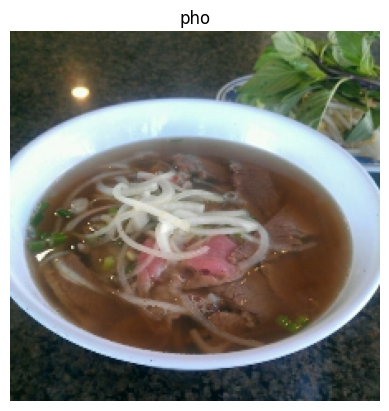

In [41]:
# We can still plot our preprocessed image as long as we
# divide by 255 (for matplotlib capatibility)
plt.imshow(preprocessed_img/255.)
plt.title(class_names[label])
plt.axis(False);

#Batch & prepare datasets

We turn our data from 101,000 image tensors and labels (train and test combined) into batches of 32 image and label pairs, thus enabling it to fit into the memory of our GPU.

https://www.tensorflow.org/guide/data_performance

Specifically, we're going to be using:

map() - maps a predefined function to a target dataset (e.g. preprocess_img() to our image tensors)

shuffle() - randomly shuffles the elements of a target dataset up buffer_size (ideally, the buffer_size is equal to the size of the dataset, however, this may have implications on memory)

batch() - turns elements of a target dataset into batches (size defined by parameter batch_size)

prefetch() - prepares subsequent batches of data whilst other batches of data are being computed on (improves data loading speed but costs memory)

Extra: cache() - caches (saves them for later) elements in a target dataset, saving loading time (will only work if your dataset is small enough to fit in memory, standard Colab instances only have 12GB of memory)

In [42]:
# Map preprocessing function to training data (and paralellize)
train_data=train_data.map(map_func=preprocess_img,num_parallel_calls=tf.data.AUTOTUNE)
# Shuffle train_data and turn it into batches and prefetch it (load it faster)
train_data=train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

# Map prepreprocessing function to test data
test_data=test_data.map(preprocess_img,num_parallel_calls=tf.data.AUTOTUNE)
# Turn test data into batches (don't need to shuffle)
test_data=test_data.batch(32).prefetch(tf.data.AUTOTUNE)


In [ ]:
train_data, test_data

#Create modelling callbacks

In [44]:
# Create TensorBoard callback (already have "create_tensorboard_callback()" from a previous notebook)
from helper_functions import create_tensorboard_callback

# Create ModelCheckpoint callback to save model's progress

checkpoint_path = "model_checkpoints/cp.weights.h5" # saving weights requires ".ckpt" extension
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor="val_accuracy", # save the model weights with best validation accuracy
                                                      save_best_only=True, # only save the best weights
                                                      save_weights_only=True, # only save model weights (not whole model)
                                                      verbose=0) # don't print out whether or not model is being saved

#Setup mixed precision training

Normally, tensors in TensorFlow default to the float32 datatype (unless otherwise specified).
In computer science, float32 is also known as single-precision floating-point format. The 32 means it usually occupies 32 bits in computer memory.
Well, if you thought since float32 meant single-precision floating-point, you might've guessed float16 means half-precision floating-point format. And if you did, you're right! And if not, no trouble, now you know.

As a result, using mixed precision training can improve your performance on modern GPUs (those with a compute capability score of 7.0+) by up to 3x.



In [45]:
#Turn on mixed precision
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy(policy="mixed_float16") # set global policy to mixed precision

In [46]:
mixed_precision.global_policy()

<DTypePolicy "mixed_float16">

# Build feature extraction model

In [47]:
from tensorflow.keras import layers

#Create the base model
input_shape=(224,224,3)
base_model=tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable=False # freeze base model layers

#Create Functional model
inputs=layers.Input(shape=input_shape,name="input_layer")
# Note: EfficientNetBX models have rescaling built-in but if your model didn't you could have a layer like below
# x = layers.Rescaling(1./255)(x)
x=base_model(inputs,training=False) #set base model to inference mode only
x=layers.GlobalAveragePooling2D(name="pooling_layer")(x)
x=layers.Dense(len(class_names))(x)  # want one output neuron per class
# Separate activation of output layer so we can output float32 activations
outputs=layers.Activation("softmax",dtype=tf.float32, name="softmax_float32")(x)
model=tf.keras.Model(inputs,outputs)


# Compile the model
model.compile(loss="sparse_categorical_crossentropy", # Use sparse_categorical_crossentropy when labels are *not* one-hot
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])



In [48]:
# Check out our model
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb0 (Functional)          │ (None, 7, 7, 1280)          │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pooling_layer                        │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 101)                 │         129,381 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ softmax_float32 (Activation)         │ (None, 101)                 │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,178,952 (15.94 MB)

 Trainable params: 129,381 (505.39 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [49]:
# Check the dtype_policy attributes of layers in our model
for layer in model.layers:
  print(layer.name,layer.trainable,layer.dtype,layer.dtype_policy)

input_layer True float32 <DTypePolicy "mixed_float16">
efficientnetb0 False float32 <DTypePolicy "mixed_float16">
pooling_layer True float32 <DTypePolicy "mixed_float16">
dense_1 True float32 <DTypePolicy "mixed_float16">
softmax_float32 True float32 <DTypePolicy "float32">


In [50]:
# Check the layers in the base model and see what dtype policy they're using
for layer in model.layers[1].layers[:20]:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_layer_1 False float32 <DTypePolicy "mixed_float16">
rescaling_2 False float32 <DTypePolicy "mixed_float16">
normalization_1 False float32 <DTypePolicy "mixed_float16">
rescaling_3 False float32 <DTypePolicy "mixed_float16">
stem_conv_pad False float32 <DTypePolicy "mixed_float16">
stem_conv False float32 <DTypePolicy "mixed_float16">
stem_bn False float32 <DTypePolicy "mixed_float16">
stem_activation False float32 <DTypePolicy "mixed_float16">
block1a_dwconv False float32 <DTypePolicy "mixed_float16">
block1a_bn False float32 <DTypePolicy "mixed_float16">
block1a_activation False float32 <DTypePolicy "mixed_float16">
block1a_se_squeeze False float32 <DTypePolicy "mixed_float16">
block1a_se_reshape False float32 <DTypePolicy "mixed_float16">
block1a_se_reduce False float32 <DTypePolicy "mixed_float16">
block1a_se_expand False float32 <DTypePolicy "mixed_float16">
block1a_se_excite False float32 <DTypePolicy "mixed_float16">
block1a_project_conv False float32 <DTypePolicy "mixed_fl

#Fit the feature extraction model

In [51]:
# Import the necessary module for model checkpointing
from tensorflow.keras.callbacks import ModelCheckpoint

# Define the model_checkpoint callback
checkpoint_path = "model_checkpoints/cp.weights.h5"  # define the checkpoint path
model_checkpoint = ModelCheckpoint(filepath=checkpoint_path,
                                   save_weights_only=True, # set to False to save the entire model
                                   save_best_only=True, # save only the best model
                                   monitor="val_loss") # monitor validation loss

# Turn off all warnings except for errors
tf.get_logger().setLevel('ERROR')

# Fit the model with callbacks
history_101_food_classes_feature_extract=model.fit(train_data,
                                                   epochs=3,
                                                   steps_per_epoch=len(train_data),
                                                   validation_data=test_data,
                                                   validation_steps=int(0.15*len(test_data)),
                                                   callbacks=[create_tensorboard_callback("training_logs",
                                                                                          "efficientnetb0_101_classes_all_data_feature_extract"),
                                                                                          model_checkpoint])

Saving TensorBoard log files to: training_logs/efficientnetb0_101_classes_all_data_feature_extract/20240827-062922
Epoch 1/3
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 226s 83ms/step - accuracy: 0.4376 - loss: 2.4493 - val_accuracy: 0.6488 - val_loss: 1.3156
Epoch 2/3


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


2368/2368 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.6472 - val_loss: 1.3251
Epoch 3/3
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 176s 73ms/step - accuracy: 0.6298 - loss: 1.4430 - val_accuracy: 0.6796 - val_loss: 1.1818


In [52]:
#Evaluate model on whole test dataset
results_feature_extract_model=model.evaluate(test_data)
results_feature_extract_model

790/790 ━━━━━━━━━━━━━━━━━━━━ 57s 72ms/step - accuracy: 0.6808 - loss: 1.1915


[1.184517741203308, 0.6819801926612854]

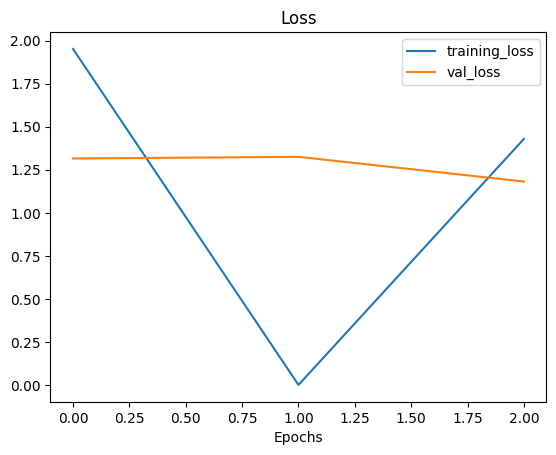

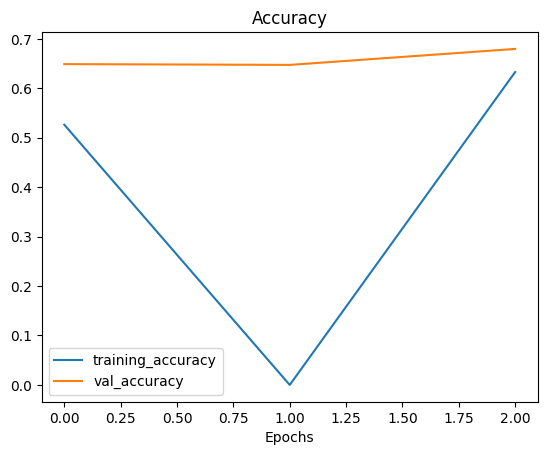

In [53]:
plot_loss_curves(history_101_food_classes_feature_extract)

In [54]:
# 1. Create a function to recreate the original model
def create_model():
  # Create base model
  input_shape = (224, 224, 3)
  base_model = tf.keras.applications.efficientnet.EfficientNetB0(include_top=False)
  base_model.trainable = False # freeze base model layers

  # Create Functional model
  inputs = layers.Input(shape=input_shape, name="input_layer")
  # Note: EfficientNetBX models have rescaling built-in but if your model didn't you could have a layer like below
  # x = layers.Rescaling(1./255)(x)
  x = base_model(inputs, training=False) # set base_model to inference mode only
  x = layers.GlobalAveragePooling2D(name="pooling_layer")(x)
  x = layers.Dense(len(class_names))(x) # want one output neuron per class
  # Separate activation of output layer so we can output float32 activations
  outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x)
  model = tf.keras.Model(inputs, outputs)

  return model




In [55]:
# 2. Create and compile a new version of the original model (new weights)
created_model=create_model()
created_model.compile(loss="sparse_categorical_crossentropy",
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=["accuracy"])

#3. Load saved weights
created_model.load_weights(checkpoint_path)

#4. Evaluate the model with loaded weights
results_created_model_with_loaded_weights =created_model.evaluate(test_data)

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'loss_scale_optimizer', because it has 4 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 6 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


790/790 ━━━━━━━━━━━━━━━━━━━━ 60s 66ms/step - accuracy: 0.6779 - loss: 1.1742


#Save the whole model to file

In [60]:
 ## Saving model to Google Drive (optional)

# Create save path to drive
save_dir = "drive/MyDrive/tensorflow_course/food_vision/07_efficientnetb0_feature_extract_model_mixed_precision/"
os.makedirs(save_dir, exist_ok=True) # Make directory if it doesn't exist

# Save model with .h5 extension
model.save(save_dir + "food_vision.h5") # Add .h5 extension to the filename

In [2]:
import os
# Saving locally on your PC
save_dir_local = r"D:\Projects\GenAF_AI_APIs\genaf_ai_apis_backend\models"
os.makedirs(save_dir_local, exist_ok=True)  # Make directory if it doesn't exist
model.save(os.path.join(save_dir_local, "food_vision.h5"))  # Save model locally

NameError: name 'model' is not defined

In [ ]:
# Save model locally (if you're using Google Colab, your saved model will Colab instance terminates)
#save_dir = "07_efficientnetb0_feature_extract_model_mixed_precision"
#model.save(save_dir)

In [62]:
# Load model previously saved above
loaded_saved_model = tf.keras.models.load_model(save_dir + "food_vision.h5") # Add the filename to the directory path

In [61]:
# Load model previously saved above
#loaded_saved_model = tf.keras.models.load_model(save_dir)

ValueError: File format not supported: filepath=drive/MyDrive/tensorflow_course/food_vision/07_efficientnetb0_feature_extract_model_mixed_precision/. Keras 3 only supports V3 `.keras` files and legacy H5 format files (`.h5` extension). Note that the legacy SavedModel format is not supported by `load_model()` in Keras 3. In order to reload a TensorFlow SavedModel as an inference-only layer in Keras 3, use `keras.layers.TFSMLayer(drive/MyDrive/tensorflow_course/food_vision/07_efficientnetb0_feature_extract_model_mixed_precision/, call_endpoint='serving_default')` (note that your `call_endpoint` might have a different name).

In [63]:
# Check the layers in the base model and see what dtype policy they're using
for layer in loaded_saved_model.layers[1].layers[:20]: # check only the first 20 layers to save output space
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_layer_1 True float32 <DTypePolicy "mixed_float16">
rescaling_2 False float32 <DTypePolicy "mixed_float16">
normalization_1 False float32 <DTypePolicy "mixed_float16">
rescaling_3 False float32 <DTypePolicy "mixed_float16">
stem_conv_pad False float32 <DTypePolicy "mixed_float16">
stem_conv False float32 <DTypePolicy "mixed_float16">
stem_bn False float32 <DTypePolicy "mixed_float16">
stem_activation False float32 <DTypePolicy "mixed_float16">
block1a_dwconv False float32 <DTypePolicy "mixed_float16">
block1a_bn False float32 <DTypePolicy "mixed_float16">
block1a_activation False float32 <DTypePolicy "mixed_float16">
block1a_se_squeeze False float32 <DTypePolicy "mixed_float16">
block1a_se_reshape False float32 <DTypePolicy "mixed_float16">
block1a_se_reduce False float32 <DTypePolicy "mixed_float16">
block1a_se_expand False float32 <DTypePolicy "mixed_float16">
block1a_se_excite False float32 <DTypePolicy "mixed_float16">
block1a_project_conv False float32 <DTypePolicy "mixed_flo

In [64]:
# Check loaded model performance (this should be the same as results_feature_extract_model)
results_loaded_saved_model = loaded_saved_model.evaluate(test_data)
results_loaded_saved_model

790/790 ━━━━━━━━━━━━━━━━━━━━ 59s 66ms/step - accuracy: 0.6801 - loss: 1.1908


[1.1845170259475708, 0.6819801926612854]

# Preparing our model's layers for fine-tuning

In [ ]:
# Download the saved model from Google Storage
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/07_efficientnetb0_feature_extract_model_mixed_precision.zip

In [ ]:
# Unzip the SavedModel downloaded from Google Stroage
!mkdir downloaded_gs_model # create new dir to store downloaded feature extraction model
!unzip 07_efficientnetb0_feature_extract_model_mixed_precision.zip -d downloaded_gs_model

In [ ]:
#Load and evaluate downloaded model
loaded_gs_model=tf.keras.models.load_model("downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision")

In [ ]:
loaded_gs_model.summary()

In [ ]:
# Check loaded model performance
results_loaded_gs_model=loaded_gs_model.evaluate(test_data)


In [ ]:
results_loaded_gs_model

In [ ]:
for layer in loaded_gs_model.layers:
  layer.trainable=True # set all layers to trainable
  print(layer.name, layer.trainable, layer.dtype,layer.dtype_policy) # make sure loaded model is using mixed precision dtype_policy ("mixed_float16")

In [ ]:
# Check the layers in the base model and see what dtype policy they're using
for layer in loaded_gs_model.layers[1].layers[:20]:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

In [ ]:
# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
early_stop=tf.keras.callbacks.EarlyStopping(monitor='val_loss', #watch the val loss metric
                                            patience=3)  # if val loss decreases for 3 epochs in a row, stop training

# Create ModelCheckpoint callback to save best model during fine-tuning
checkpoint_path="fine_tune_checkpoints/"
model_checkpoint=tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                    save_best_only=True,
                                                    monitor="val_loss")

In [ ]:
# Creating learning rate reduction callback. ReduceLROnPlateau callback helps to tune the learning rate for you.

reduce_lr=tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                               factor=0.2, # multiply the learning rate by 0.2 (reduce by 5x)
                                               patience=2,
                                               verbose=1, # print out when learning rate goes down
                                               min_lr=1e-7
                                                )

In [ ]:

# Compile the model. We'll use sparse categorical crossentropy as the loss and since we're fine-tuning, we'll use a 10x lower learning rate than the Adam optimizers default (1e-4 instead of 1e-3).
loaded_gs_model.compile(loss="sparse_categorical_crossentropy", # sparse_categorical_crossentropy for labels that are *not* one-hot
                        optimizer=tf.keras.optimizers.Adam(0.0001), # 10x lower learning rate than the default
                        metrics=["accuracy"]
                        )

In [ ]:
# Start to fine-tune (all layers)
history_101_food_classes_all_data_fine_tune=loaded_gs_model.fit(train_data,
                                                                epochs=100,
                                                                steps_per_epoch=len(train_data),
                                                                validation_data=test_data,
                                                                validation_steps=int(0.15*len(test_data)), # validation during training on 15% of test data
                                                                callbacks=[create_tensorboard_callback("training_logs", "efficientb0_101_classes_all_data_fine_tuning"), # track the model training logs
                                                                   model_checkpoint, # save only the best model during training
                                                                   early_stop, # stop model after X epochs of no improvements
                                                                   reduce_lr]
                                                                )# reduce the learning rate after X epochs of no improvements

In [ ]:
# # Save model to Google Drive
loaded_gs_model.save("/content/drive/MyDrive/tensorflow_course/food_vision/07_efficientnetb0_fine_tuned_101_classes_mixed_precision/")

# Download fine-tuned model from Google Storage

In [ ]:
# Download and evaluate fine-tuned model from Google Storage
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/07_efficientnetb0_fine_tuned_101_classes_mixed_precision.zip

In [ ]:
# Unzip fine-tuned model
!mkdir downloaded_fine_tuned_gs_model # create separate directory for fine-tuned model downloaded from Google Storage
!unzip 07_efficientnetb0_fine_tuned_101_classes_mixed_precision -d downloaded_fine_tuned_gs_model

In [ ]:
# Load in fine-tuned model from Google Storage and evaluate
loaded_fine_tuned_gs_model = tf.keras.models.load_model("downloaded_fine_tuned_gs_model/07_efficientnetb0_fine_tuned_101_classes_mixed_precision")

In [ ]:
# Get a model summary (same model architecture as above)
loaded_fine_tuned_gs_model.summary()

In [ ]:
# Note: Even if you're loading in the model from Google Storage, you will still need to load the test_data variable for this cell to work
results_downloaded_fine_tuned_gs_model = loaded_fine_tuned_gs_model.evaluate(test_data)
results_downloaded_fine_tuned_gs_model